In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation

%matplotlib inline

Using TensorFlow backend.


#### Data with many null values

In [2]:
bs_df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv')

### First 20 instances

In [3]:
df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv',
                 dtype={
                     'Timestamp': np.int64,
                     'Open': np.float64,
                     'High': np.float64,
                     'Low': np.float64,
                     'Close': np.float64,
                     'Volume_(BTC)': np.float64,
                     'Volume_(Currency)': np.float64,
                     'Weighted_Price': np.float64
                 }).sort_values(by=['Timestamp'])

In [4]:
df = df.set_index('Timestamp')

# Ensure that there exists an instance for each minute
df = df.reindex(range(df.index[0], df.index[-1], 60), fill_value=np.nan)

df.reset_index(level=0, inplace=True)

df['Timestamp'] = df['Timestamp'].apply(lambda t: datetime.utcfromtimestamp(t))

df.head(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,2014-12-01 05:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-01 05:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-01 05:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-01 05:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-12-01 05:38:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014-12-01 05:39:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014-12-01 05:40:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
8,2014-12-01 05:41:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014-12-01 05:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Step at 1minute granularity

### First 20 instances after the interpolation

In [5]:
df.interpolate(inplace=True)
df.head(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
1,2014-12-01 05:34:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
2,2014-12-01 05:35:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
3,2014-12-01 05:36:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
4,2014-12-01 05:37:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
5,2014-12-01 05:38:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
6,2014-12-01 05:39:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
7,2014-12-01 05:40:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
8,2014-12-01 05:41:00,301.590909,301.590909,301.590909,301.590909,0.01,3.015909,301.590909
9,2014-12-01 05:42:00,303.181818,303.181818,303.181818,303.181818,0.01,3.031818,303.181818


Number of instances

In [6]:
len(df)

2074707

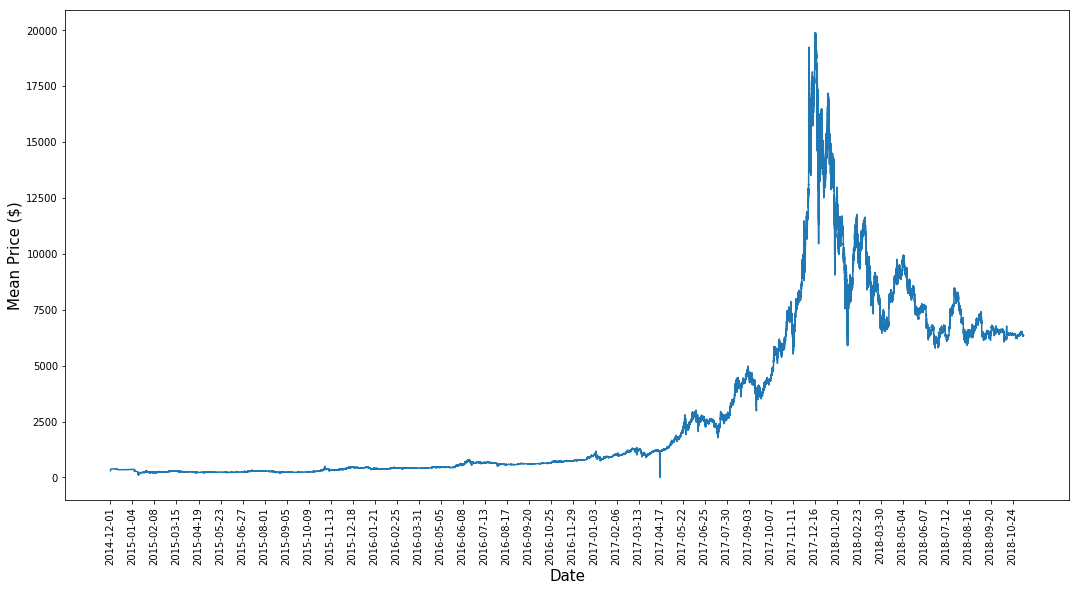

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
ts = df['Timestamp'].tolist()[::50000]
xticks = (t.strftime('%Y-%m-%d') for t in ts)
plt.xticks(range(0,df.shape[0],50000),xticks,rotation=90)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean Price ($)',fontsize=15)
plt.show()

### Map Data to Day granularity

In [8]:
df['Date'] = df['Timestamp'].apply(lambda t: t.date())
daily_info = df.groupby('Date').agg({
    'Open': lambda opens: opens.iloc[0],     # Opening value of the day
    'Close': lambda closes: closes.iloc[-1], # Closing value of the day
    'Low' : np.min,                          # Lowest value of the day
    'High': np.max,                          # Highest value of the day
    'Volume_(BTC)': np.sum                   # Sum of the volumes of the minutes in the day
}).reset_index(level=0)
daily_info['Mean'] = (daily_info['High'] + daily_info['Close']) / 2
daily_info.head(20)

,Date,Open,Close,Low,High,Volume_(BTC),Mean
0,2014-12-01,300.000000,375.300221,300.000000,375.300221,21.873404,375.300221
1,2014-12-02,375.305372,377.958639,375.305372,378.000000,1941.398508,377.979319
2,2014-12-03,377.958464,377.667052,377.010000,378.000000,169.819855,377.833526
3,2014-12-04,377.661850,377.516951,377.100000,377.661850,15.942718,377.589400
4,2014-12-05,377.517264,377.968047,377.517264,377.968047,19.541246,377.968047
5,2014-12-06,377.968361,377.026909,377.026909,378.000000,69.366556,377.513455
6,2014-12-07,377.029428,375.979636,375.979636,377.029428,179.692800,376.504532
7,2014-12-08,375.985646,376.261203,375.000000,376.270654,289.471801,376.265929
8,2014-12-09,376.284210,395.789505,376.274764,395.790466,182.990802,395.789985
9,2014-12-10,395.804021,368.564913,360.500000,398.000000,27.285516,383.282456


In [9]:
len(daily_info) # Number of days for which data is present or interpolated

1441

## Observations

### Evaluating Time Series Forecasting

In time series forecasting we have to choose the input and the output of the model. We can choose for example to predict $x_{t + 1}$ at a given time $t$ by giving in input to the model $x_t$ or giving in input $(x_{t-k}, x_{t - k + 1},...,x_{t})$ where $k$ is the window size, i.e. how much of the past the predictor can observe. Both cases are called *One-Step Ahead* Forecasting.

This can be useful in some cases, such as weather forecasting. In the case of trading though, we would like to predict far in the future. This can be done by iteratively letting the model predict the next values based *not* on the actual values of the window but on the previously predicted values i.e. given in input $(\hat x_{t-k}, \hat x_{t - k + 1},..., \hat x_{t})$. [[1]](https://github.com/kmsravindra/ML-AI-experiments/blob/master/AI/LSTM-time_series/LSTM%20-%20Sine%20wave%20predictor.ipynb) [[2]](https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f)

We must be careful on how we evaluate our model since what can happen is that we feed the network the actual data $(x_{t-k}, x_{t - k + 1},...,x_{t})$ for multiple values of $t$ producing the predicted values $\hat x_{t+1} \approx x_t, \hat x_{t+2} \approx x_{t+1}, \hat x_{t+3} \approx x_{t+2}, \hat x_{t+4} \approx x_{t+3}$ (similar to the *Persistence Model*) which produces a good result in terms of RMSE (since the data has some inertia in fluctuatng) but not really useful given that at each timestep the model can see the previous *actual* data and thus does not depend by previous wrong predictions. [[3]](https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning/) [[4]](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb)

![lag](images/lag.png)

Alternatively we can perform a *Multi Step* Forecast i.e. letting the model predict the next $m$ values $x_{t+1}, ..., x_{t+m}$

### Data Preprocessing

Another issue we must consider is how to preprocess the data. We cannot normalize it over the full time period since given the spike of the BTC price in December 2017 a good portion of the data will be normalized close to 0.

A good way would be normalize the data in the time window, i.e. by representing each datapoint in the window as a ratio (positive or negative) of increase/decrease in value with respect to the first data point of the window. In this case the data points will be values in the range $[-1, 1]$ thus a good activation function would be $tanh$. [Function normalize_windows [5]](https://towardsdatascience.com/using-recurrent-neural-networks-to-predict-bitcoin-btc-prices-c4ff70f9f3e4#2dd7)

Another way can be differencing the data which means mapping point $x_t$ to $x_t' = x_t - x_{t-1}$

These processes are called making the data *stationary*, the data does not depend by trends.

The windows can either overlap or not [[6]](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/)

## Model

In [32]:
IN_TIMESTEPS  = 30   # A month
OUT_TIMESTEPS = 6
TRAIN_RATIO = 0.7
X_cols = ["Open", "Close", "Mean"]
Y_cols = ["Mean"]

EPOCHS = 500
BATCH_SZ = 256

In [33]:
def as_strided(df, X_stride_len, Y_stride_len, X_cols, Y_cols):
    X = []
    Y = []
    for i in range(len(df) - X_stride_len - Y_stride_len + 1):
        X.append(df[X_cols].iloc[i : i + X_stride_len].values)
        Y.append(df[Y_cols].iloc[i + X_stride_len : i + X_stride_len + Y_stride_len].values.reshape(-1))
    
    Y = np.array(Y)
    return np.array(X), Y.reshape(-1,1) if Y_stride_len == 1 else Y

In [34]:
X_raw, Y_raw = as_strided(daily_info, IN_TIMESTEPS, OUT_TIMESTEPS, X_cols, Y_cols)

### Transform each window

Each window is "normalized" thus representing each value as percentage in increase or decrease of the first value in the window

$$
    w' = \frac{w}{w_0} - 1
$$

In [35]:
def transform_to_prc(w):
    return w / w[0] - 1

X = np.apply_along_axis(transform_to_prc, 1, X_raw)
Y = (Y_raw / X_raw[:,0,2].reshape((-1,1))) - 1

In [36]:
split = int(len(X) * TRAIN_RATIO)

X_raw_test, Y_raw_test = X_raw[split:], Y_raw[split:]
X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]

In [37]:
def build_lstm_nn(out_size, timesteps, input_shape):
    model = Sequential()
    model.add(LSTM(
        out_size,
        input_shape=(timesteps, input_shape)
    ))
    return model

In [38]:
model = build_lstm_nn(OUT_TIMESTEPS, IN_TIMESTEPS, len(X_cols))

In [39]:
model.compile(loss='mean_absolute_error', optimizer='adam')

In [40]:
model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SZ)

Epoch 1/500
984/984 [==============================] - 1s 632us/step - loss: 0.2013
Epoch 2/500
984/984 [==============================] - 0s 56us/step - loss: 0.1980
Epoch 3/500
984/984 [==============================] - 0s 58us/step - loss: 0.1948
Epoch 4/500
984/984 [==============================] - 0s 57us/step - loss: 0.1918
Epoch 5/500
984/984 [==============================] - 0s 56us/step - loss: 0.1888
Epoch 6/500
984/984 [==============================] - 0s 50us/step - loss: 0.1858
Epoch 7/500
984/984 [==============================] - 0s 53us/step - loss: 0.1830
Epoch 8/500
984/984 [==============================] - 0s 51us/step - loss: 0.1802
Epoch 9/500
984/984 [==============================] - 0s 49us/step - loss: 0.1774
Epoch 10/500
984/984 [==============================] - 0s 55us/step - loss: 0.1747
Epoch 11/500
984/984 [==============================] - 0s 57us/step - loss: 0.1719
Epoch 12/500
984/984 [==============================] - 0s 54us/step - loss: 0.1693


984/984 [==============================] - 0s 51us/step - loss: 0.0628
Epoch 99/500
984/984 [==============================] - 0s 54us/step - loss: 0.0626
Epoch 100/500
984/984 [==============================] - 0s 47us/step - loss: 0.0625
Epoch 101/500
984/984 [==============================] - 0s 53us/step - loss: 0.0623
Epoch 102/500
984/984 [==============================] - 0s 50us/step - loss: 0.0622
Epoch 103/500
984/984 [==============================] - 0s 52us/step - loss: 0.0620
Epoch 104/500
984/984 [==============================] - 0s 55us/step - loss: 0.0619
Epoch 105/500
984/984 [==============================] - 0s 52us/step - loss: 0.0617
Epoch 106/500
984/984 [==============================] - 0s 58us/step - loss: 0.0616
Epoch 107/500
984/984 [==============================] - 0s 48us/step - loss: 0.0615
Epoch 108/500
984/984 [==============================] - 0s 49us/step - loss: 0.0613
Epoch 109/500
984/984 [==============================] - 0s 49us/step - loss: 0.

984/984 [==============================] - 0s 62us/step - loss: 0.0548
Epoch 195/500
984/984 [==============================] - 0s 54us/step - loss: 0.0547
Epoch 196/500
984/984 [==============================] - 0s 50us/step - loss: 0.0547
Epoch 197/500
984/984 [==============================] - 0s 54us/step - loss: 0.0546
Epoch 198/500
984/984 [==============================] - 0s 52us/step - loss: 0.0546
Epoch 199/500
984/984 [==============================] - 0s 53us/step - loss: 0.0545
Epoch 200/500
984/984 [==============================] - 0s 51us/step - loss: 0.0545
Epoch 201/500
984/984 [==============================] - 0s 54us/step - loss: 0.0545
Epoch 202/500
984/984 [==============================] - 0s 58us/step - loss: 0.0544
Epoch 203/500
984/984 [==============================] - 0s 49us/step - loss: 0.0544
Epoch 204/500
984/984 [==============================] - 0s 55us/step - loss: 0.0543
Epoch 205/500
984/984 [==============================] - 0s 56us/step - loss: 0

984/984 [==============================] - 0s 57us/step - loss: 0.0519
Epoch 291/500
984/984 [==============================] - 0s 56us/step - loss: 0.0518
Epoch 292/500
984/984 [==============================] - 0s 55us/step - loss: 0.0518
Epoch 293/500
984/984 [==============================] - 0s 49us/step - loss: 0.0518
Epoch 294/500
984/984 [==============================] - 0s 57us/step - loss: 0.0517
Epoch 295/500
984/984 [==============================] - 0s 54us/step - loss: 0.0517
Epoch 296/500
984/984 [==============================] - 0s 55us/step - loss: 0.0517
Epoch 297/500
984/984 [==============================] - 0s 57us/step - loss: 0.0517
Epoch 298/500
984/984 [==============================] - 0s 54us/step - loss: 0.0516
Epoch 299/500
984/984 [==============================] - 0s 60us/step - loss: 0.0516
Epoch 300/500
984/984 [==============================] - 0s 57us/step - loss: 0.0516
Epoch 301/500
984/984 [==============================] - 0s 49us/step - loss: 0

984/984 [==============================] - 0s 59us/step - loss: 0.0501
Epoch 387/500
984/984 [==============================] - 0s 59us/step - loss: 0.0500
Epoch 388/500
984/984 [==============================] - 0s 53us/step - loss: 0.0500
Epoch 389/500
984/984 [==============================] - 0s 49us/step - loss: 0.0500
Epoch 390/500
984/984 [==============================] - 0s 60us/step - loss: 0.0500
Epoch 391/500
984/984 [==============================] - 0s 51us/step - loss: 0.0500
Epoch 392/500
984/984 [==============================] - 0s 48us/step - loss: 0.0500
Epoch 393/500
984/984 [==============================] - 0s 60us/step - loss: 0.0500
Epoch 394/500
984/984 [==============================] - 0s 52us/step - loss: 0.0499
Epoch 395/500
984/984 [==============================] - 0s 54us/step - loss: 0.0499
Epoch 396/500
984/984 [==============================] - 0s 55us/step - loss: 0.0499
Epoch 397/500
984/984 [==============================] - 0s 49us/step - loss: 0

984/984 [==============================] - 0s 52us/step - loss: 0.0489
Epoch 483/500
984/984 [==============================] - 0s 55us/step - loss: 0.0488
Epoch 484/500
984/984 [==============================] - 0s 56us/step - loss: 0.0488
Epoch 485/500
984/984 [==============================] - 0s 59us/step - loss: 0.0488
Epoch 486/500
984/984 [==============================] - 0s 52us/step - loss: 0.0488
Epoch 487/500
984/984 [==============================] - 0s 54us/step - loss: 0.0488
Epoch 488/500
984/984 [==============================] - 0s 56us/step - loss: 0.0488
Epoch 489/500
984/984 [==============================] - 0s 51us/step - loss: 0.0488
Epoch 490/500
984/984 [==============================] - 0s 55us/step - loss: 0.0488
Epoch 491/500
984/984 [==============================] - 0s 56us/step - loss: 0.0488
Epoch 492/500
984/984 [==============================] - 0s 53us/step - loss: 0.0488
Epoch 493/500
984/984 [==============================] - 0s 53us/step - loss: 0

In [41]:
Y_pred = model.predict(X_test)
Y_pred_raw = (Y_pred + 1) *  X_raw_test[:,0,2][:,np.newaxis]

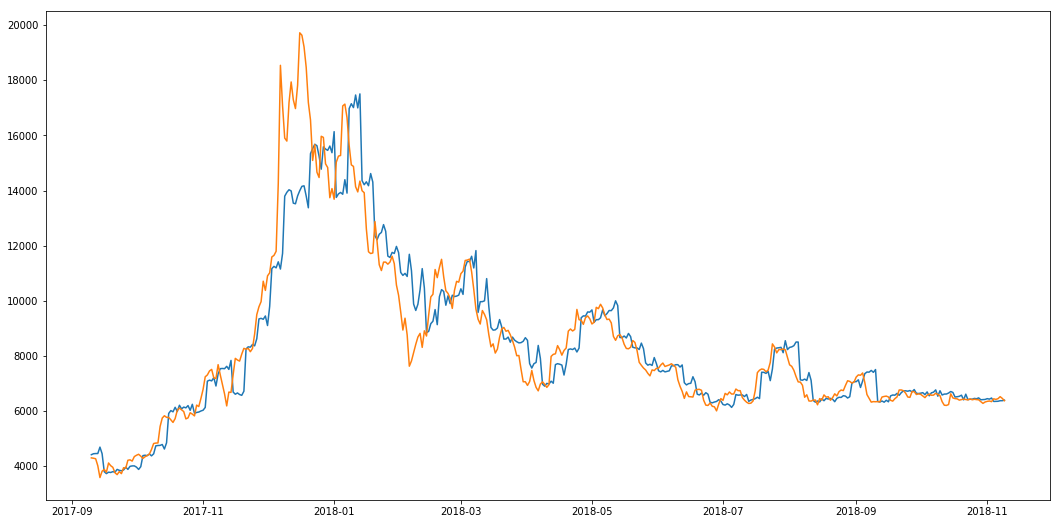

In [42]:
plt.figure(figsize = (18,9))

dates = daily_info["Date"][split + IN_TIMESTEPS:].values

Y_pred_plt = Y_pred_raw[::OUT_TIMESTEPS].reshape(-1)
Y_test_plt = Y_raw_test[::OUT_TIMESTEPS].reshape(-1)

dates = dates[:len(dates) - (len(dates) - len(Y_test_plt))]

plt.plot(dates, Y_pred_plt)
plt.plot(dates, Y_test_plt)